# The Library

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
import re
from sklearn import discriminant_analysis
from sklearn.preprocessing import LabelEncoder
from fitter import Fitter, get_common_distributions, get_distributions


In [2]:
import warnings
warnings.filterwarnings('ignore')

# The Necessary Files

In [3]:
current_dir = os.getcwd()
folder = '/data/results_international/'
result_file = 'adj_final_results.csv'
rubicology_file = 'all_games_RWC2023_fixed.csv'

# Expected score gap by elo gap/ relation between elo and score against or for?

In [4]:
result_df = pd.read_csv(current_dir+folder+result_file)
result_df['date'] = pd.to_datetime(result_df['date'])
result_df['point_gap'] = result_df.apply(lambda row: abs(row['Score A']-row['Score B']) , axis=1)
result_df.head(2)

Unnamed: 0       date    Team A   Team B  Score A  Score B  \
0           0 1882-12-16     Wales  England        0        2   
1           1 1883-01-08  Scotland    Wales        3        1   

                       Tourn Venue       City  Neut.  Country  elo_home  \
0  Home_Nations_Championship   NaN    Swansea   True      NaN    1000.0   
1  Home_Nations_Championship   NaN  Edinburgh   True      NaN    1000.0   

     elo_away  proba_home_win   elo_gap  outcome  point_gap  
0  1000.00000        0.500000   0.00000      0.0          2  
1   982.97151        0.524486  17.02849      1.0          2

In [5]:
#relationship between point gap and elo gap
result_positive_elo_gap = result_df
result_positive_elo_gap["elo_gap"] = result_positive_elo_gap["elo_gap"].abs()

[Text(0, 0.5, 'Point Gap'), Text(0.5, 0, 'Elo Gap')]

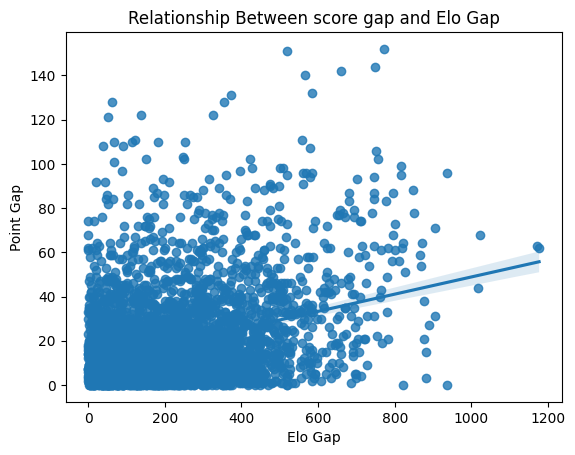

In [6]:
elo_gap_ax = sns.regplot(data=result_positive_elo_gap, y="point_gap", x="elo_gap")
elo_gap_ax.set(title='Relationship Between score gap and Elo Gap')
elo_gap_ax.set(ylabel='Point Gap', xlabel='Elo Gap')

[11.22398114  1.00385823  0.51257302]


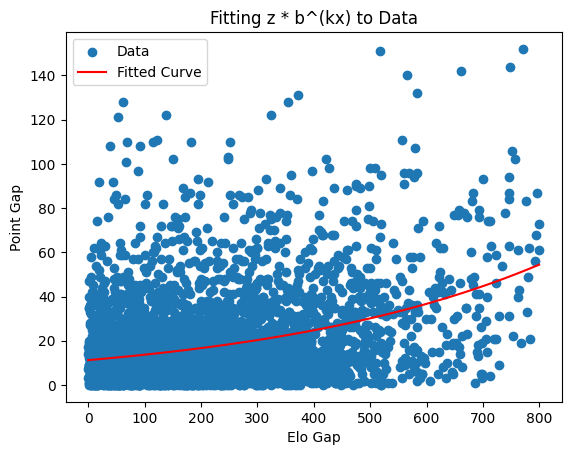

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

grouped_result = result_positive_elo_gap.groupby('elo_gap')['point_gap'].median().reset_index()
result_positive_elo_gap["elo_gap"] = (result_positive_elo_gap["elo_gap"] /10).round(0)*10
X = np.array(grouped_result['elo_gap']).reshape(-1, 1)
Y = np.array(grouped_result['point_gap']).reshape(-1, 1)


grouped_result = grouped_result[grouped_result['elo_gap']<800]
# Assuming result_positive_elo_gap contains your data
x_data = grouped_result['elo_gap']
y_data = grouped_result['point_gap']

# Define the function
def custom_func(x, z, b, k):
    return z * (b ** (k * x))

# Fit the curve to the data
popt, pcov = curve_fit(custom_func, x_data, y_data)
print(popt)
# Get the optimized parameters
z_opt, b_opt, k_opt = popt

# Generate points for the curve
x_curve = np.linspace(min(x_data), max(x_data), 100)
y_curve = custom_func(x_curve, z_opt, b_opt, k_opt)

# Plot the data and the fitted curve
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_curve, y_curve, 'r-', label='Fitted Curve')
plt.xlabel('Elo Gap')
plt.ylabel('Point Gap')
plt.title('Fitting z * b^(kx) to Data')
plt.legend()
plt.show()

In [8]:
excluded_tournaments = ['Rugby_World_Cup', 'Rugby_World_Cup_Pool_A', 'Rugby_World_Cup_Pool_B', 'Rugby_World_Cup_Pool_C', 'Rugby_World_Cup_Pool_D']


# Filter train data
result_positive_elo_gap_train = result_positive_elo_gap[
    (~result_positive_elo_gap['Tourn'].isin(excluded_tournaments)) & 
    (result_positive_elo_gap['date'].dt.year != 2023)
]

# Filter test data
result_positive_elo_gap_test = result_positive_elo_gap[
    (result_positive_elo_gap['Tourn'].isin(excluded_tournaments)) & 
    (result_positive_elo_gap['date'].dt.year == 2023) 
]
#estimate point gap
X = np.array(result_positive_elo_gap_train['elo_gap']).reshape(-1,1)
y= np.array(result_positive_elo_gap_train['point_gap']).reshape(-1,1)
X_test = np.array(result_positive_elo_gap_test['elo_gap']).reshape(-1,1)
Y_test = np.array(result_positive_elo_gap_test['point_gap']).reshape(-1,1)

<Axes: xlabel='elo_gap', ylabel='Count'>

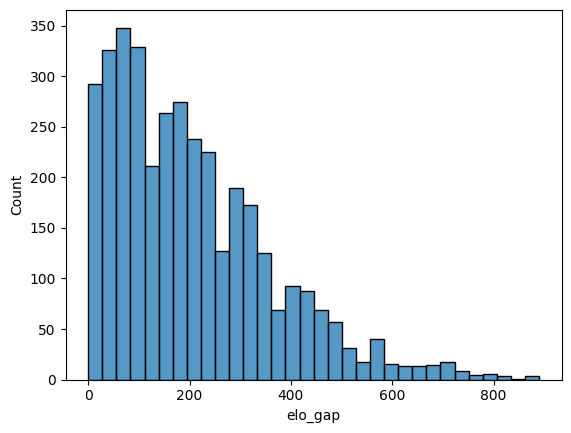

In [9]:
#plot the elo gaps
sns.histplot(data=result_positive_elo_gap_train, x='elo_gap')

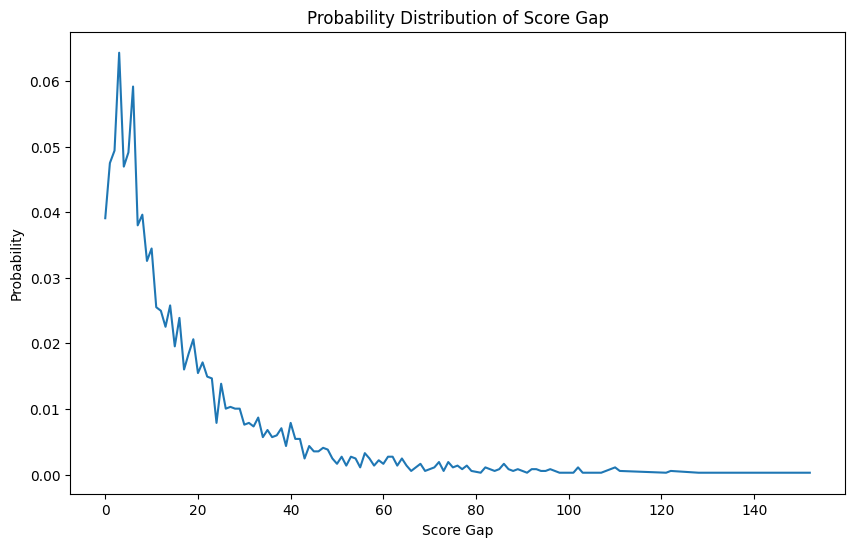

In [9]:
# Group by score gaps, then count occurrences
score_gap_counts_total = result_positive_elo_gap_train.groupby('point_gap').size().reset_index(name='Count')

# Calculate the total count of score gaps
total_gap_counts = score_gap_counts_total['Count'].sum()

# Calculate the probability of each score gap happening
score_gap_counts_total['Probability'] = score_gap_counts_total['Count'] / total_gap_counts

# Plot the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=score_gap_counts_total, x='point_gap', y='Probability')
plt.xlabel('Score Gap')
plt.ylabel('Probability')
plt.title('Probability Distribution of Score Gap')
plt.show()

Text(0.5, 0, 'Score Gap')

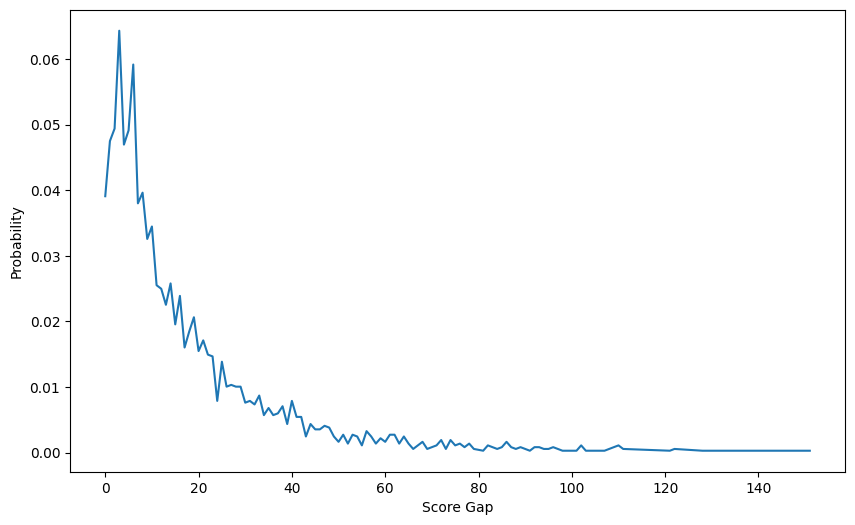

In [10]:
#do the same, but only take the score that represent 95% of the possibilities
# Calculate the cumulative probability
topN = 1

score_gap_counts_total['Cumulative Probability'] = score_gap_counts_total['Probability'].cumsum()
# Filter the DataFrame to include only the scores representing the top 95% of probabilities
top_N_percent_scores = score_gap_counts_total[score_gap_counts_total['Cumulative Probability'] <= topN]
# Plot the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=top_N_percent_scores, x='point_gap', y='Probability')
plt.xlabel('Score Gap')

2024-05-10 16:26:50.190 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED _fit distribution (taking more than 30 seconds)
2024-05-10 16:26:50.959 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.006861)
2024-05-10 16:26:51.705 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted anglit distribution with error=0.017949)
2024-05-10 16:26:53.142 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cosine distribution with error=0.016737)
2024-05-10 16:26:54.462 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted arcsine distribution with error=0.013639)
2024-05-10 16:26:55.183 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted argus distribution with error=0.019649)
2024-05-10 16:26:55.209 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted bradford distribution with error=0.012845)
2024-05-10 16:26:55.254 | INFO     | fitter.fitter:_fit_single_distribution:337 

sumsquare_error          aic          bic  kl_div  ks_statistic  \
johnsonsb           0.002237  1370.237693  1395.085796     inf      0.040718   
fatiguelife         0.002270  1366.915199  1385.551277     inf      0.039299   
pareto              0.002322  1375.744730  1394.380808     inf      0.041417   
halfgennorm         0.002348  1379.081397  1397.717475     inf      0.051576   
halfcauchy          0.002352  1279.776800  1292.200851     inf      0.064796   

                ks_pvalue  
johnsonsb    9.568446e-06  
fatiguelife  2.212509e-05  
pareto       6.264471e-06  
halfgennorm  5.852476e-09  
halfcauchy   6.790683e-14

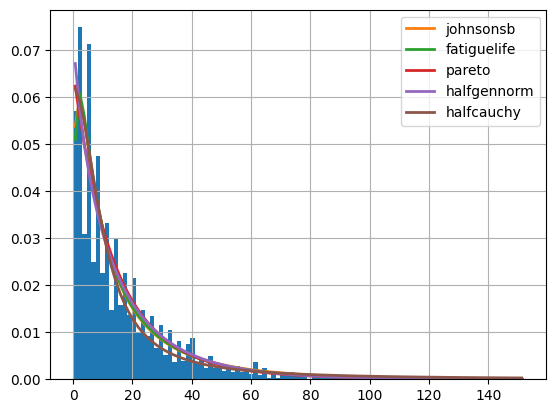

In [11]:
from fitter import Fitter, get_common_distributions, get_distributions

f = Fitter(result_positive_elo_gap_train['point_gap'])
f.fit()
f.summary()

In [15]:
print(f.get_best(method = 'sumsquare_error'))
f.fitted_param["johnsonsb"]

{'johnsonsb': {'a': 2.155749734964961, 'b': 0.8030933549735537, 'loc': -0.6512061182858886, 'scale': 173.5217156413969}}


(2.155749734964961, 0.8030933549735537, -0.6512061182858886, 173.5217156413969)

<Axes: xlabel='Score', ylabel='Count'>

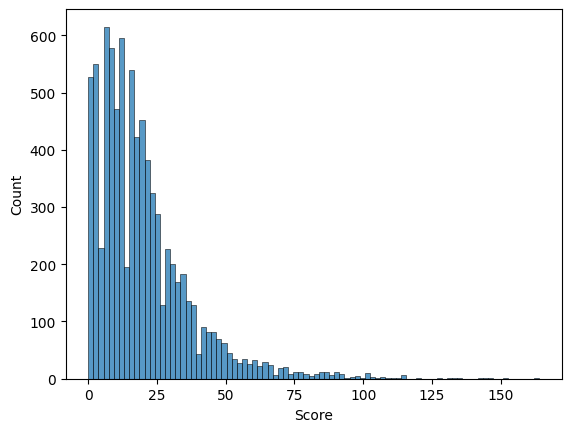

In [20]:
#for each team, is there a lot of variation in score
scores_team_a= result_positive_elo_gap[['Team A','Score A', 'elo_home']].rename(columns={'Team A':'Team', 'Score A': 'Score', 'elo_home':'Elo'})
scores_team_b= result_positive_elo_gap[['Team B','Score B', 'elo_away']].rename(columns={'Team B':'Team', 'Score B': 'Score', 'elo_away':'Elo'})
all_scores = pd.concat([scores_team_a,scores_team_b])[['Team', 'Score', 'Elo']]
sns.histplot(data=all_scores, x='Score')

In [11]:
predicted_y = [custom_func(x, z_opt, b_opt, k_opt ) for x in X]
predicted_y_test =[custom_func(x, z_opt, b_opt, k_opt ) for x in X_test]

rmse_train_linear = np.sqrt(np.mean((predicted_y - y)**2))
rmse_test_linear = np.sqrt(np.mean((predicted_y_test - Y_test)**2))


print(f'rmse train linear: {rmse_train_linear}')
print(f'rmse test linear: {rmse_test_linear}')


result_positive_elo_gap_train['predicted_gap'] = predicted_y
result_positive_elo_gap_test['predicted_gap'] = predicted_y_test

rmse train linear: 18.6753527096679
rmse test linear: 17.15837272161071


In [23]:
result_positive_elo_gap_test

Unnamed: 0       date        Team A        Team B  Score A  Score B  \
3961        3961 2023-09-08        France   New Zealand       27       13   
3962        3962 2023-09-09     Australia       Georgia       35       15   
3963        3963 2023-09-09       England     Argentina       27       10   
3964        3964 2023-09-09         Italy       Namibia       52        8   
3965        3965 2023-09-09       Ireland       Romania       82        8   
3966        3966 2023-09-10         Wales          Fiji       32       26   
3967        3967 2023-09-10         Japan         Chile       42       12   
3968        3968 2023-09-10  South Africa      Scotland       18        3   
3969        3969 2023-09-14        France       Uruguay       27       12   
3970        3970 2023-09-15   New Zealand       Namibia       71        3   
3971        3971 2023-09-16       Ireland         Tonga       59       16   
3972        3972 2023-09-16         Samoa         Chile       43       10   
3973        3973 2023-09-16         Wales      Portugal       28        8   
3974        3974 2023-09-17  South Africa       Romania       76        0   
3975        3975 2023-09-17       England         Japan       34       12   
3976        3976 2023-09-17     Australia          Fiji       15       22   
3977        3977 2023-09-20         Italy       Uruguay       38       17   
3978        3978 2023-09-21        France       Namibia       96        0   
3979        3979 2023-09-22     Argentina         Samoa       19       10   
3980        3980 2023-09-23  South Africa       Ireland        8       13   
3981        3981 2023-09-23       Georgia      Portugal       18       18   
3982        3982 2023-09-23       England         Chile       71        0   
3983        3983 2023-09-24      Scotland         Tonga       45       17   
3984        3984 2023-09-24         Wales     Australia       40        6   
3985        3985 2023-09-27       Uruguay       Namibia       36       26   
3986        3986 2023-09-28         Japan         Samoa       28       22   
3987        3987 2023-09-29   New Zealand         Italy       96       17   
3988        3988 2023-09-30     Argentina         Chile       59        5   
3989        3989 2023-09-30      Scotland       Romania       84        0   
3990        3990 2023-09-30          Fiji       Georgia       17       12   
3991        3991 2023-10-01  South Africa         Tonga       49       18   
3992        3992 2023-10-01     Australia      Portugal       34       14   
3993        3993 2023-10-05   New Zealand       Uruguay       73        0   
3994        3994 2023-10-06        France         Italy       60        7   
3995        3995 2023-10-07       England         Samoa       18       17   
3996        3996 2023-10-07       Ireland      Scotland       36       14   
3997        3997 2023-10-07         Wales       Georgia       43       19   
3998        3998 2023-10-08         Tonga       Romania       45       24   
3999        3999 2023-10-08         Japan     Argentina       27       39   
4000        4000 2023-10-08          Fiji      Portugal       23       24   
4001        4001 2023-10-14         Wales     Argentina       17       29   
4002        4002 2023-10-14       Ireland   New Zealand       24       28   
4003        4003 2023-10-15       England          Fiji       30       24   
4004        4004 2023-10-15        France  South Africa       28       29   
4005        4005 2023-10-20     Argentina   New Zealand        6       44   
4006        4006 2023-10-21       England  South Africa       15       16   
4007        4007 2023-10-27     Argentina       England       23       26   
4008        4008 2023-10-28   New Zealand  South Africa       11       12   

                       Tourn                      Venue               City  \
3961  Rugby_World_Cup_Pool_A            Stade de France        Saint-Denis   
3962  Rugby_World_Cup_Pool_C            Stade de France        Saint-Denis  

# First exploration: Any upsets?

In [12]:
#Conditions on wins
condition_1 = result_positive_elo_gap_test['elo_gap']>100
condition_2 = (result_positive_elo_gap_test['proba_home_win']<0.5) & (result_positive_elo_gap_test['outcome']>0)
condition_3 = (result_positive_elo_gap_test['proba_home_win']>0.5) & (result_positive_elo_gap_test['outcome']<1)
#conditions on score 
condition_4 = result_positive_elo_gap_test['point_gap'] <result_positive_elo_gap_test['predicted_gap']-7
## we will look at score gap smaller than expectd
upsets = result_positive_elo_gap_test[((condition_1) & (condition_2 |condition_3 )) | (condition_1 & condition_4 ) ]
upsets.head(5)

Unnamed: 0       date       Team A       Team B  Score A  Score B  \
3961        3961 2023-09-08       France  New Zealand       27       13   
3969        3969 2023-09-14       France      Uruguay       27       12   
3970        3970 2023-09-15  New Zealand      Namibia       71        3   
3971        3971 2023-09-16      Ireland        Tonga       59       16   
3976        3976 2023-09-17    Australia         Fiji       15       22   

                       Tourn                    Venue               City  \
3961  Rugby_World_Cup_Pool_A          Stade de France        Saint-Denis   
3969  Rugby_World_Cup_Pool_A      Stade Pierre-Mauroy  Villeneuve-d'Ascq   
3970  Rugby_World_Cup_Pool_A      Stadium de Toulouse           Toulouse   
3971  Rugby_World_Cup_Pool_B    Stade de la Beaujoire             Nantes   
3976  Rugby_World_Cup_Pool_C  Stade Geoffroy-Guichard      Saint-Étienne   

      Neut.  Country     elo_home     elo_away  proba_home_win  elo_gap  \
3961   True      NaN  1663.837464  1867.245237        0.236691    200.0   
3969   True      NaN  1722.493700  1032.485255        0.981513    690.0   
3970   True      NaN  1808.589001   787.353393        0.997209   1020.0   
3971   True      NaN  1770.960147  1007.729390        0.987794    760.0   
3976   True      NaN  1518.071955  1380.071845        0.688774    140.0   

      outcome  point_gap         predicted_gap  
3961      1.0         14  [16.656768022835934]  
3969      1.0         15   [43.81553008426256]  
3970      1.0         68   [84.04470469162837]  
3971      1.0         43  [50.307577331132975]  
3976      0.0          7  [14.796452170378771]

# PCA Baby

In [13]:
from sklearn import decomposition
from sklearn import datasets

In [14]:

rub_wc_df = pd.read_csv(current_dir+'/data/'+rubicology_file )
variables_start = list(rub_wc_df.columns)
variable_end = []
for variable in variables_start:
     if re.search(r'\sA(?!\S)', variable):
        new_variable = re.sub(r'\sA(?!\S)', ' ', variable)
        variable_end.append(new_variable.strip())
variable_a = ['Date', 'Game ID']
variable_b =  ['Date', 'Game ID']

for variable in variable_end:
    if 'Possession' not in variable:
        variable_a.append(f'{variable} A')
    else:
        one, two = variable.split('  - ')
        one = f'{one} A'
        variable = ' - '.join([one, two])
        variable_a.append(variable)

for variable in variable_end:
    if 'Possession' not in variable:
        variable_b.append(f'{variable} B')
    else:
        one, two = variable.split('  - ')
        one = f'{one} B'
        variable = ' - '.join([one, two])
        variable_b.append(variable)
        

rub_wc_df_a = rub_wc_df[variable_a ]
rub_wc_df_b = rub_wc_df[variable_b ]

rub_wc_df_a.columns = rub_wc_df_a.columns.str.replace(r'\sA(?!\S)', '', regex=True)
rub_wc_df_b.columns = rub_wc_df_b.columns.str.replace(r'\sB(?!\S)', '', regex=True)
split_df = pd.concat([rub_wc_df_a,rub_wc_df_b ])
split_df.to_csv(current_dir+folder+'split_df_teams.csv', index=False)

In [15]:
def do_pca_team(df, n_components=2):
    # Assuming target_names is a list of your categorical target names
    label_encoder = LabelEncoder()
    target_names =df['Team']
    y_encoded = label_encoder.fit_transform(df['Team'])

    pca = decomposition.PCA(n_components)

    X=split_df.drop(columns=['Date','Game ID', 'Team'])

    X_r = pca.fit(X).transform(X)
 
    # Percentage of variance explained for each components
    print(
        "explained variance ratio (first two components): %s"
        % str(pca.explained_variance_ratio_)
    )


    plt.figure()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
              '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
              '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5']
    lw = 2
    
    for color, i, target_name in zip(colors, range(20), target_names):
        plt.scatter(
            X_r[y_encoded == i, 0], X_r[y_encoded == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
        )
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.title("PCA of IRIS dataset")
    plt.show()
    
    return pca

def do_lda_team(df, n_components=2):
    label_encoder = LabelEncoder()
    target_names =df['Team']
    y_encoded = label_encoder.fit_transform(df['Team'])
    lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=n_components)
    X_r = lda.fit(X, y_encoded).transform(X)
    
    
    plt.figure()
    for color, i, target_name in zip(colors, range(20), target_names):
        plt.scatter(
            X_r[y_encoded == i, 0], X_r[y_encoded == i, 1], alpha=0.8, color=color, label=target_name
        )
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.title("LDA of IRIS dataset")
    
    plt.show()
    return lda

explained variance ratio (first two components): [0.89994903 0.04599245]


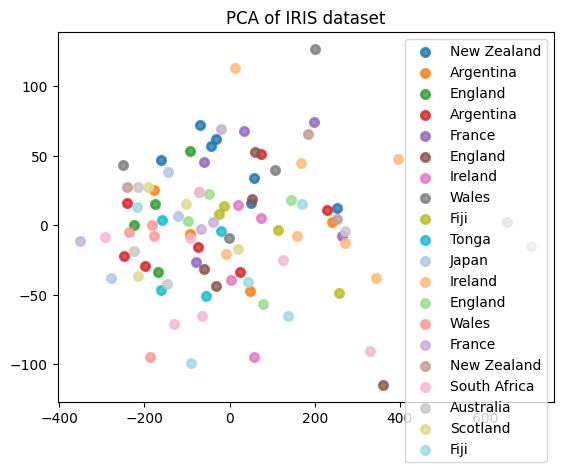

PCA(n_components=2)

In [44]:
do_pca_team(split_df)

In [16]:
#create a df with relatice perfomance: the percentage if each action taken by each team
def create_relative_ratio_df(df):
    ids = df['Game ID'].unique()
    for unique_id in ids:
        rows = df[df['Game ID'] == unique_id]
        # sum for each variable across the 2 rows
        sum_row = rows.drop(columns=['Game ID', 'Date', 'Team']).sum(axis=0)
        # divide each row that has the Game ID = id by the sum_rows
        rows.loc[:, ~rows.columns.isin(['Game ID', 'Date', 'Team'])] = rows.drop(columns=['Game ID', 'Date', 'Team']).div(sum_row, axis=1)
        # update the original DataFrame with the scaled values
        df.loc[df['Game ID'] == unique_id, ~df.columns.isin(['Game ID', 'Date', 'Team'])] = rows.drop(columns=['Game ID', 'Date', 'Team']).values
    df.sort_values(by='Game ID', inplace=True)
    df.fillna(0,inplace=True)
    df['Outcome'] = df['Score'].apply(lambda x: 1 if x > 0.5 else (0.5 if x == 0.5 else 0))
    return df

In [55]:
relative_df_ratio = create_relative_ratio_df(split_df)
relative_df_ratio.reset_index(inplace=True, drop=True)
#ealtive_transpose_ratio = relative_df_ratio.transpose().reset_index(drop=True)
relative_df_ratio.head(5)

Date  Game ID         Team     Score  Possession - Overall  \
0  8-Sep-2023    87834       France  0.675000                  0.49   
1  8-Sep-2023    87834  New Zealand  0.325000                  0.51   
2  9-Sep-2023    87835      Namibia  0.133333                  0.48   
3  9-Sep-2023    87835        Italy  0.866667                  0.52   
4  9-Sep-2023    87836      Ireland  0.911111                  0.67   

   Possession - 1st half  Possession - 2nd half     Tries  Conversions  \
0                   0.44                   0.53  0.500000          1.0   
1                   0.56                   0.47  0.500000          0.0   
2                   0.53                   0.44  0.125000          0.0   
3                   0.47                   0.56  0.875000          1.0   
4                   0.57                   0.76  0.923077          1.0   

   Penalties  ...  Total Rucks  Lineouts Successful  Lineouts Thrown  \
0   0.833333  ...     0.424460             0.565217         0.560000   
1   0.166667  ...     0.575540             0.434783         0.440000   
2   0.500000  ...     0.566434             0.310345         0.363636   
3   0.500000  ...     0.433566             0.689655         0.636364   
4   0.000000  ...     0.738095             0.500000         0.545455   

   Scrums Successful  Scrums Total  Penalties Conceded Own Half  \
0           0.444444      0.416667                     0.222222   
1           0.555556      0.583333                     0.777778   
2           0.500000      0.500000                     0.454545   
3           0.500000      0.500000                     0.545455   
4           0.500000      0.500000                     0.222222   

   Penalties Conceded Opp Half  Yellow Cards  Red Cards  Outcome  
0                     0.285714           0.0        0.0      1.0  
1                     0.714286           1.0        0.0      0.0  
2                     0.727273           1.0        0.0      0.0  
3                     0.272727           0.0        0.0      1.0  
4                     0.375000           0.0        0.0      1.0  

[5 rows x 34 columns]

In [31]:
#create a df with relatice perfomance: the percentage if each action taken by each team
def create_relative_diff_df(df):
    ids = df['Game ID'].unique()
    series = []
    for unique_id in ids:
        rows = df[df['Game ID'] == unique_id]
        row_1 = rows.iloc[0].drop(['Game ID', 'Date', 'Team'])
        row_2 = rows.iloc[1].drop(['Game ID', 'Date', 'Team'])
        new_1 = row_1 - row_2
        new_2 = row_2 - row_1
        row_1_header= rows.iloc[0][['Game ID', 'Date', 'Team']]
        row_2_header= rows.iloc[1][['Game ID', 'Date', 'Team']]
        new_1 = pd.concat([row_1_header,new_1 ])
        new_2 = pd.concat([row_2_header,new_2 ])
        
        series.append(new_1)
        series.append(new_2)
        # update the original DataFrame with the scaled values
    df = pd.concat(series, axis=1)
    #df.fillna(0,inplace=True)
    #df['Outcome'] = df['Score'].apply(lambda x: 1 if x > 0.5 else (0.5 if x == 0.5 else 0))
    return df

In [50]:
relative_df = create_relative_diff_df(split_df)
realtive_transpose = relative_df.transpose().reset_index(drop=True)
realtive_transpose.head(5)

Game ID         Date          Team Score Possession - Overall  \
0   87881  28-Oct-2023   New Zealand    -1                   20   
1   87881  28-Oct-2023  South Africa     1                  -20   
2   87880  27-Oct-2023     Argentina    -3                    6   
3   87880  27-Oct-2023       England     3                   -6   
4   87879  21-Oct-2023       England    -1                   12   

  Possession - 1st half Possession - 2nd half Tries Conversions Penalties  \
0                    26                    16     1           0        -2   
1                   -26                   -16    -1           0         2   
2                   -10                    18     0           0        -1   
3                    10                   -18     0           0         1   
4                     4                    18    -1          -1         1   

   ... Rucks Successful Total Rucks Lineouts Successful Lineouts Thrown  \
0  ...               59          64                  14              12   
1  ...              -59         -64                 -14             -12   
2  ...               46          45                   1               0   
3  ...              -46         -45                  -1               0   
4  ...               15          13                  -8              -9   

  Scrums Successful Scrums Total Penalties Conceded Own Half  \
0                -8           -9                          -2   
1                 8            9                           2   
2                -3           -5                          -1   
3                 3            5                           1   
4                -4           -1                           0   

  Penalties Conceded Opp Half Yellow Cards Red Cards  
0                          -3           -1         1  
1                           3            1        -1  
2                           0            0         0  
3                           0            0         0  
4                           3            0         0  

[5 rows x 33 columns]

# Next, explore what a mean performance is and for each metric, define a strength scalr or weakness depending on the rank 

In [58]:
relative_df_ratio.columns

Index(['Date', 'Game ID', 'Team', 'Score', 'Possession - Overall',
       'Possession - 1st half', 'Possession - 2nd half', 'Tries',
       'Conversions', 'Penalties', 'Metres', 'Defenders Beaten',
       'Clean breaks', 'Gain line Carries', 'Passes', 'Offloads',
       'Turnovers won', 'Kicks from Hand', 'Rucks Won', 'Tackles Made',
       'Tackles Missed', 'Goal Kicks Successful', 'Goal Kicks Attempted',
       'Rucks Successful', 'Total Rucks', 'Lineouts Successful',
       'Lineouts Thrown', 'Scrums Successful', 'Scrums Total',
       'Penalties Conceded Own Half', 'Penalties Conceded Opp Half',
       'Yellow Cards', 'Red Cards', 'Outcome'],
      dtype='object')

In [83]:
# for each team average the relative performance% 
relative_df_ratio_average = relative_df_ratio.drop(['Game ID', 'Date'], axis=1).groupby('Team').median().reset_index()
#for each team, get in what percentil amongst the teams it lies. create a dict for each team
def get_rank(grouped_median_dict):
    dico = {}
    #for each team
    for col in grouped_median_dict.drop('Team',axis=1).columns:
        sorted = grouped_median_dict[[col, 'Team']].sort_values(ascending=False, by=col)
        dico[col] =list(sorted['Team'].values )
          #for ind in grouped_median_dict.index:
        #country = grouped_median_dict['Team'][ind]  
    #for each variable
    return dico

In [85]:
relative_df_ratio_average.head(5)

Team     Score  Possession - Overall  Possession - 1st half  \
0  Argentina  0.590909                 0.530                  0.540   
1  Australia  0.552703                 0.485                  0.555   
2      Chile  0.133402                 0.455                  0.455   
3    England  0.555556                 0.550                  0.540   
4       Fiji  0.489362                 0.540                  0.530   

   Possession - 2nd half     Tries  Conversions  Penalties    Metres  \
0                  0.550  0.500000     0.500000   0.666667  0.568266   
1                  0.440  0.666667     0.550000   0.500000  0.514206   
2                  0.505  0.138889     0.071429   0.000000  0.367176   
3                  0.460  0.500000     0.333333   0.571429  0.553991   
4                  0.560  0.500000     0.500000   0.200000  0.508929   

   Defenders Beaten  ...  Total Rucks  Lineouts Successful  Lineouts Thrown  \
0          0.666667  ...     0.600000             0.611111         0.500000   
1          0.459567  ...     0.529647             0.442424         0.421795   
2          0.482886  ...     0.501082             0.436842         0.477730   
3          0.482759  ...     0.485294             0.466667         0.458333   
4          0.539683  ...     0.596685             0.555556         0.589744   

   Scrums Successful  Scrums Total  Penalties Conceded Own Half  \
0           0.466667      0.444444                     0.461538   
1           0.409091      0.416667                     0.577381   
2           0.279221      0.303846                     0.708333   
3           0.600000      0.625000                     0.375000   
4           0.562500      0.619048                     0.384615   

   Penalties Conceded Opp Half  Yellow Cards  Red Cards  Outcome  
0                     0.500000      0.000000        0.0      1.0  
1                     0.619048      0.000000        0.0      0.5  
2                     0.452991      0.583333        0.0      0.0  
3                     0.555556      0.000000        0.0      1.0  
4                     0.400000      1.000000        0.0      0.0  

[5 rows x 32 columns]

In [89]:
#next, do max normalisation for each column, to have each value between 0 and 1. we<ll have percentages in function of the best performance
columns_to_apply = relative_df_ratio_average.columns.drop('Team')
relative_df_ratio_average[columns_to_apply] = relative_df_ratio_average[columns_to_apply].apply(lambda col: col / max(col))

In [92]:
relative_df_ratio_average.head(2)

Team     Score  Possession - Overall  Possession - 1st half  \
0  Argentina  0.695549              0.929825               0.947368   
1  Australia  0.650577              0.850877               0.973684   

   Possession - 2nd half     Tries  Conversions  Penalties    Metres  \
0               0.948276  0.500000         0.50   0.761905  0.905285   
1               0.758621  0.666667         0.55   0.571429  0.819165   

   Defenders Beaten  ...  Total Rucks  Lineouts Successful  Lineouts Thrown  \
0          0.932569  ...     1.000000             1.000000         0.777778   
1          0.642866  ...     0.882746             0.723967         0.656125   

   Scrums Successful  Scrums Total  Penalties Conceded Own Half  \
0           0.712727      0.704663                     0.651584   
1           0.624793      0.660622                     0.815126   

   Penalties Conceded Opp Half  Yellow Cards  Red Cards  Outcome  
0                     0.705882           0.0        0.0      1.0  
1                     0.873950           0.0        0.0      0.5  

[2 rows x 32 columns]

In [101]:
test = relative_df_ratio_average[relative_df_ratio_average['Team']== team].drop('Team', axis=1).values
test[0]

array([0.31949   , 0.76315789, 0.81578947, 0.71551724, 0.26111111,
       0.1984127 , 1.        , 0.56784481, 0.50497616, 0.56099456,
       0.66927325, 0.61989234, 0.61111111, 0.60454545, 0.72788698,
       0.7052736 , 0.86528799, 0.8233721 , 0.39823718, 0.41958042,
       0.7052736 , 0.73398001, 0.5182618 , 0.57228535, 0.9472028 ,
       0.97859136, 0.88067227, 0.68571429, 0.25      , 0.        ,
       0.        ])

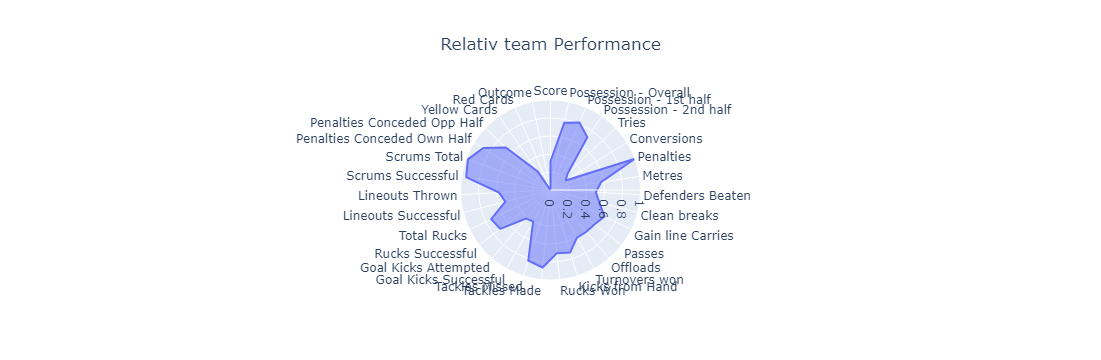

In [107]:
#do a test with one team
import plotly.express as px
import pandas as pd
team = 'Tonga'
df = relative_df_ratio_average[relative_df_ratio_average['Team']== team].drop('Team', axis=1)
fig = px.line_polar(df, r=df.values[0], theta= df.columns , line_close=True,  title='Relativ team Performance')
fig.update_layout(title_x=0.5)
fig.update_traces(fill='toself')
fig.show()

In [41]:
relative_df = create_relative_df(split_df)
relative_df.to_csv(current_dir+folder+'split_df_relative.csv', index=False)
relative_df_y = relative_df['Outcome']
relative_df_x = relative_df.drop(columns=['Outcome','Score','Tries', 'Conversions'])
#first do the PCA, apply embedding, and the LFA

In [46]:
label_encoder = LabelEncoder()
target_names =df['Team']
y_encoded = label_encoder.fit_transform(df['Team'])
pca = decomposition.PCA()

X=relative_df_x.drop(columns=['Date','Game ID', 'Team'])
pca.fit(X)
transformed = pca.transform(X)

Text(0.5, 0, 'Number of Components')

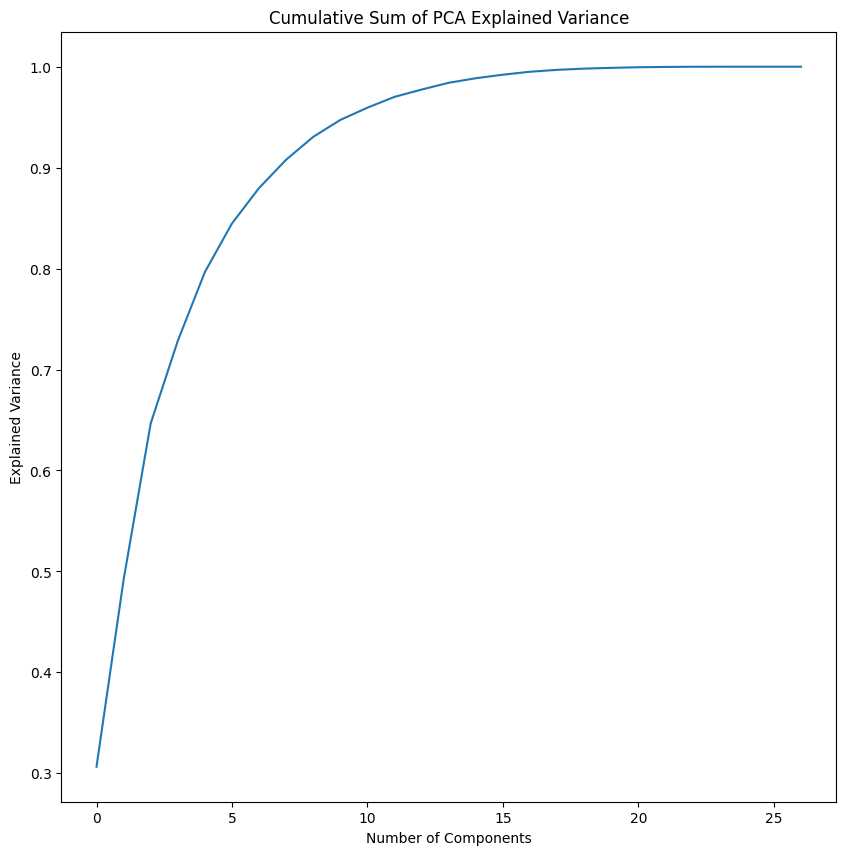

In [47]:
cumulative_sum = np.cumsum(pca.explained_variance_ratio_, axis=0)
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
ax.plot(cumulative_sum)
ax.set_title('Cumulative Sum of PCA Explained Variance')
ax.set_ylabel('Explained Variance')
ax.set_xlabel('Number of Components')

In [48]:
def top_N(cumulative_sum, percentage):
    topN = np.where(cumulative_sum > percentage)[0][0]
    print(f'{percentage*100}% in ' + '%d' % (topN+1) + ' components')
    return topN

top99 = top_N(cumulative_sum, 0.99)
transformed_99 = transformed[:,0:top99]

99.0% in 16 components


In [49]:
lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(np.array(transformed_99), np.array(y_encoded ))
transformed = lda.transform(transformed_99)

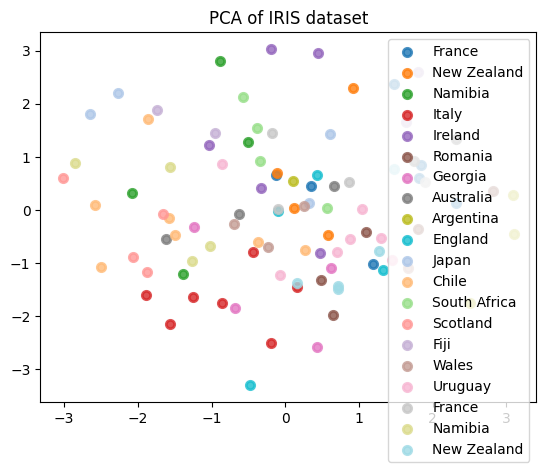

In [50]:
#split the variable 
plt.figure()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
          '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5']
lw = 2

for color, i, target_name in zip(colors, range(20), target_names):
    plt.scatter(
        transformed[y_encoded == i, 0], transformed[y_encoded == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of IRIS dataset")
plt.show()

In [38]:
#test classification results
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier(max_iter=100).fit(transformed, y_encoded)
clf.score(transformed, y_encoded)

KeyboardInterrupt: 

In [ ]:
#use neural network for embedding